In [1]:
%load_ext autoreload
%autoreload 2
%cd ..

/home/gefan/Projects/scoreoperator


In [8]:
import jax
import jax.numpy as jnp
import matplotlib.pyplot as plt

from src.data.synthetic_shapes import Circle
from src.utils.trainer import TrainerModule, Approximator
from configs.circles_eulerian import get_circles_eulerian_config as get_config
from src.utils.plotting import plot_shape_with_pts, plot_trajectories

2024-05-01 11:12:47.552472: W external/xla/xla/service/gpu/nvptx_compiler.cc:744] The NVIDIA driver's CUDA version is 12.2 which is older than the ptxas CUDA version (12.3.107). Because the driver is older than the ptxas version, XLA is disabling parallel compilation, which may slow down compilation. You should update your NVIDIA driver or use the NVIDIA-provided CUDA forward compatibility packages.


initial condition shape: (16, 2), target shape: (16, 2)


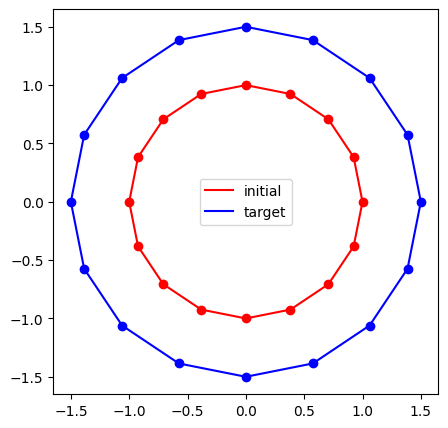

In [3]:
small_circle = Circle(r=1.0)
large_circle = Circle(r=1.5)

n_training_sample_pts = 16
small_circle_sample = small_circle.sample(n_training_sample_pts)
large_circle_sample = large_circle.sample(n_training_sample_pts)
print(f"initial condition shape: {small_circle_sample.shape}, target shape: {large_circle_sample.shape}")

fig, ax = plt.subplots(1, 1, figsize=(5, 5))
ax = plot_shape_with_pts(ax, small_circle_sample, color='r', label='initial')
ax = plot_shape_with_pts(ax, large_circle_sample, color='b', label='target')
ax.set_aspect('equal')
ax.legend()

In [22]:
config = get_config()
config.sde_name = "eulerian"
config.sde.s0 = small_circle
config.sde.kappa = 0.2
config.sde.sigma = 0.1

config.diffusion.approximator = "g2score"
config.training.n_pts = n_training_sample_pts
trainer = TrainerModule(
    config
)

In [23]:
xss, tss, grads, _ = next(trainer.dataloader)
print(xss.shape)

(16, 100, 32)


<Axes: xlabel='$x$', ylabel='$y$'>

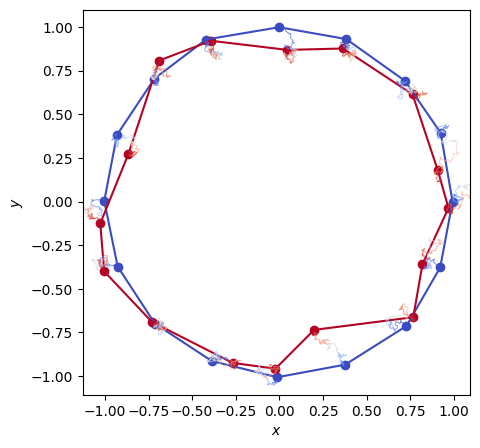

In [24]:
xs = small_circle_sample[None, :, :] + xss[0].reshape(100, n_training_sample_pts, 2)
fig, ax = plt.subplots(1, 1, figsize=(5, 5))
plot_trajectories(ax, xs, target=small_circle_sample, plot_target=False, cmap_name="coolwarm")

In [25]:
trainer.train_model(
    pretrained=False,
    load_dir="/home/gefan/Projects/scoreoperator/src/pretrained",
    prefix="circle_eulerian_16pts100"
)

Training: 100%|██████████| 100/100 [01:56<00:00,  1.17s/epoch, Epoch=99, eval_loss=16.5416, train_loss=16.6017]


In [ ]:
trainer.save_model("/home/gefan/Projects/scoreoperator/src/pretrained", prefix="circle_eulerian_16pts", step=100)

In [26]:
approx = Approximator(trainer, approximator_type=config.diffusion.approximator)

<Axes: xlabel='$x$', ylabel='$y$'>

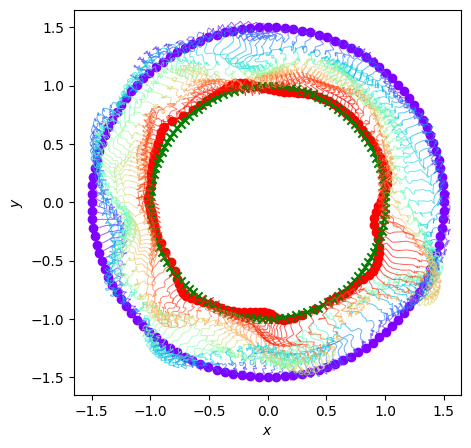

In [30]:
n_eval_sample_pts = 128
x0 = (large_circle.sample(n_eval_sample_pts) - small_circle.sample(n_eval_sample_pts)).flatten()
ts = jnp.linspace(0, 1, 200)
xs = trainer.diffuser.solve_reverse_bridge_sde(rng_key=jax.random.PRNGKey(4), x0=x0, ts=ts, approx=approx)
xs = xs.reshape(-1, n_eval_sample_pts, 2)
fig, ax = plt.subplots(1, 1, figsize=(5, 5))
plot_trajectories(ax, (xs+small_circle.sample(n_eval_sample_pts)[None, ...]), target=small_circle.sample(n_eval_sample_pts), plot_target=True, cmap_name="rainbow")